<a href="https://colab.research.google.com/github/jdescartes24/Storke-Prediction/blob/main/Stroke_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
 

In [2]:
df= pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## ***checking the Dtypes and getting an overall view of my data***

In [4]:
df.info()
# checking the Dtypes and getting an overall view of my data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# ***Checking for missing data***

In [5]:
# chceking for null values
df.isnull().sum()
# There are 201 values missing in the bmi column this will be taken care of later in the code with num selector strategey = Most Freques.

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# ***Creating a Function to help me check the calues of each of the columns in my data***

In [6]:
# cheking values of my columns to see if there are and miss spelling or out of place data
def values(x):
  x=df[x].value_counts()
  print(x)

values('id')
values('gender')
values("age")
values('hypertension')
values('heart_disease')
values('ever_married')
values('work_type')
values('Residence_type')
values('avg_glucose_level')
values('bmi')
values('smoking_status')
values('stroke')
# There were no inconsistances in my data 

16380    1
58061    1
69918    1
23238    1
4807     1
        ..
35085    1
44375    1
5464     1
50522    1
49152    1
Name: id, Length: 5110, dtype: int64
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.08       2
0.40       2
Name: age, Length: 104, dtype: int64
0    4612
1     498
Name: hypertension, dtype: int64
0    4834
1     276
Name: heart_disease, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
93.88     6
83.16     5
91.85     5
91.68     5
73.00     5
         ..
162.14    1
111.77    1
90.91     1
103.50    1
88.02     1
Name: avg_glucose_level, Length: 3979, dtype: int64
28.7    41
28.4    38
26.7    37
27.7  

# ***Checking For duplicates, and droping them if found.***

In [7]:
# checking for duplicates
df.drop_duplicates().any()

# dropping all duplicates
df.drop_duplicates(inplace=True)

# ***Here I am droping the 'id' column, because I believe it does not play a roll in predicting the data. Its just a random number applied to a patient.***

In [10]:
df.drop(columns='id',inplace= True)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# ***Creating a box plot of my data to see values like mean of stroke vs non stroke and to see were the mass of the data layed, and to aslo see the outliers.***

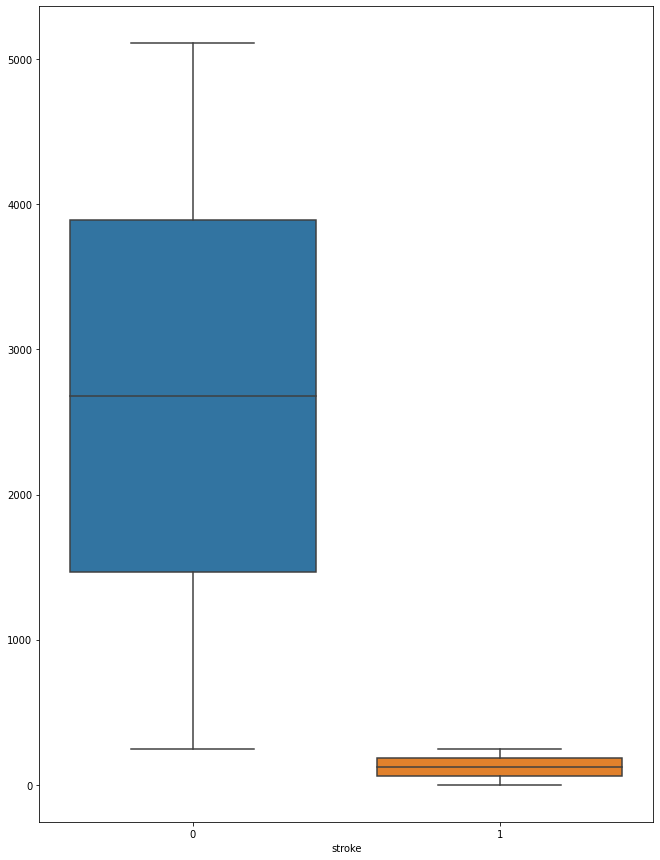

In [11]:
plt.figure(figsize=(11,15));
sns.boxplot(x='stroke', y=df.index, data=df);



# ***Here is a hist plot that gives an overall picture of the entire data set , and it's distribution.***

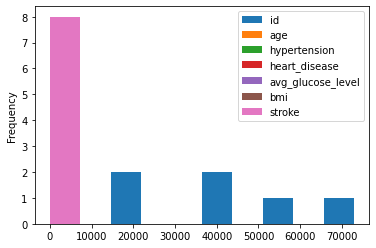

In [12]:
df.describe().plot(kind= 'hist');

# ***Creating a Coor Relation Heatmap of my data***

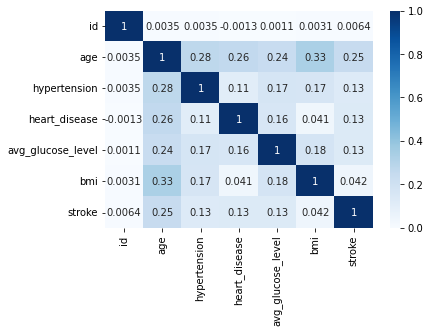

In [13]:
sns.heatmap(df.corr(), annot=True, cmap='Blues');
# There were no strong coorelations in this heat map.